# Hypothesis testing 
### Chrisian Holm Christensen

## Setup

Here's some setup code 

In [1]:
%matplotlib inline
import numpy as np
import sympy as sy
import scipy as sp
import scipy.stats 
import matplotlib.pyplot as plt 
from matplotlib import rcParams
rcParams['figure.figsize'] = [8.,8.]
rcParams['image.cmap'] = 'cividis'
rcParams['font.serif'] = ['Palatino'] + rcParams['font.serif']
rcParams['font.family'] = ['serif']
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['axes.formatter.use_mathtext'] = True
sy.init_printing()
np.random.seed(12345)

## $q\bar{q}$ scattering again 

We read in some data 

In [12]:
data1 = np.genfromtxt('Lecture8_LLH_Ratio_2_data.txt')
data2 = np.genfromtxt('Lecture8_LLH_Ratio_2a_data.txt')
len(data1)

### Older code for reuse 

We want to histogram and make maximum likelihood fits to this, so without further ado we copy these functions from a previous class. 

#### Histogramming function

In [3]:
def histogram(data,bins='auto'):
    from numpy import histogram as hist 
    from numpy import diff, sqrt
    from matplotlib.pyplot import errorbar, gca
    
    class _h: 
        def __init__(self,data,bins):
            self.y, self.b = hist(data,bins,density=True)
            self.x = (self.b[1:]+self.b[:-1])/2
            self.w = diff(self.b)
            self.e = sqrt(self.y/len(data)/self.w)
        def plot(self,*args,**kwargs):
            ax = kwargs.pop('ax',gca())
            return ax.errorbar(self.x,self.y,self.e,self.w/2,*args,**kwargs)
    
    return _h(data,bins)

#### Maximum likelyhood fit

In [4]:
def mlefit(f,data,*args,**kwargs):
    from numpy import log, sqrt, errstate
    from scipy.optimize import minimize 
    from matplotlib.pyplot import plot, gca
    
    class _mlef:
        def __init__(self,f,data,*args,**kwargs):
            self.f    = f
            opt       = minimize(lambda args: self.llh(args,data),
                                 *args,**kwargs)
            self.p    = opt.x
            self.cov  = opt.hess_inv
            self.e    = sqrt(self.cov.diagonal())
            self.nllh = -opt.fun
            
        def plot(self,x,*args,**kwargs):
            ax = kwargs.pop('ax',gca())
            return ax.plot(x,self.f(x,*self.p),*args,**kwargs)
        
        def llh(self,args,data=data):
            with errstate(invalid='ignore'):
                return -log(f(data,*args)).sum(axis=0)
            
        def __str__(self):
            txt = f'Maximum log-likelihood: {-self.nllh:.3f}\n'
            txt += 'Parameters, uncertainties, covariance:\n'
            txt += '\n'.join([f' p{i}: {p:.2f} +/- {e:.2f}\t' 
                              + '\t'.join([f'{c:.2f}' for c in self.cov[i]])
                              for i,(p,e) in enumerate(zip(self.p,self.e))])
            return txt
        
    return _mlef(f,data,*args,**kwargs)

### Visualize the data

We draw histograms of the data read in. 

In [5]:
hist1 = histogram(data1[:,0],20)
hist2 = histogram(data2[:,0],20)

fig, ax = plt.subplots(ncols=2,sharey=True,gridspec_kw=dict(wspace=0))
for hh, a in zip([hist1,hist2],ax):
    hh.plot(fmt='none',ax=a,label='Data')
    a.set_xlabel('E')
    a.set_ylabel('P(E)')

### Fit of the data 

We want to fit two PDFs to each of these - the null PDF 

$$f(E;\alpha,\beta) = \frac{1+\alpha E + \beta E^2}{2\left(\frac{\beta}{3}+1\right)}\quad E\in[-1,1]\quad,$$ 

which is properly normalized, and the alternative PDF

$$g'(E;\alpha,\beta,\gamma) = 1+\alpha E + \beta E^2 + \gamma E^3\quad E\in[-1,1]\quad,$$ 

which is _not_ normalised.  Thus, we need to calculate the normalisation of $g'$ first 

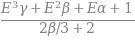

In [6]:
alpha, beta, gamma, E = sy.symbols('alpha beta gamma E',real=True)
gp = 1 + alpha*E + beta*E**2 + gamma*E**3 
i = gp.integrate((E,-1,1))
gp / i 

Thus our second _normalized_ PDF becomes 

$$g(E;\alpha,\beta,\gamma) = \frac{1 + \alpha E+\beta E^2 + \gamma E^3}{2\left(\frac{\beta}{3}+1\right)}\quad.$$ 

The two PDFs are similar enough that we will code this into a single function which we can use 

In [7]:
def pdf(E,alpha,beta,gamma=0):
    return (1+alpha*E+beta*E**2+gamma*E**3)/(2*(beta/3 + 1))

Next, we want to evaluate the two PDFs $H_0,H_1$ over our two data sets $D_1,D_2$ to obtain likelihood estimates of 

\begin{align*}
  P(D_1|H_0) &&& \text{$D_1$ given $H_0$ is true}\\
  P(D_1|H_1) &&& \text{$D_1$ given $H_1$ is true}\\
  P(D_2|H_0) &&& \text{$D_2$ given $H_0$ is true}\\
  P(D_2|H_1) &&& \text{$D_2$ given $H_1$ is true}\quad.\\
\end{align*}
  
We calculate the combinations and evaluate the MLE fit in each case 

In [10]:
comp = [[(dn,hn,mlefit(pdf,d[:,0],p0)) 
         for hn,p0 in [('H0',(0.1,0.1)),
                       ('H1',(0.1,0.1,0.1))]] 
        for dn,d in [('D1',data1),
                     ('D2',data2)]]
print(comp)

[[('D1', 'H0', <__main__.mlefit.<locals>._mlef object at 0x7f8d2b596c10>), ('D1', 'H1', <__main__.mlefit.<locals>._mlef object at 0x7f8d2b596c90>)], [('D2', 'H0', <__main__.mlefit.<locals>._mlef object at 0x7f8b16c465d0>), ('D2', 'H1', <__main__.mlefit.<locals>._mlef object at 0x7f8d2b4bea10>)]]


### Ruling out the null-hypothesis

We want to evaluate the log-likelihood ratio 

$$\Lambda(H_1,D_x) 
= -2\log\left(\frac{L(D_x|H_0)}{L(D_x|H_1)}\right) 
= -2\left(\log L(H_0|D_x)-\log L(H_1|D_x)\right) 
= -2\Delta\log L(D_x)\quad,$$ 

and the corresponding $p$-value, given by evaluating the probability of $\chi^2=-2\Delta\log L(D_x)$ and $\nu=2$. 

While we're calculating these, we also plot the data, and the fitted functions.  The plot will show the calculated $p$-value for each data set.  A large $p$-value ($>5\%$ or so) means that the null-hypothesis is _not_ rejected. 

Maximum log-likelihood: 13432.140
Parameters, uncertainties, covariance:
 p0: 0.30 +/- 0.02	0.00	0.00
 p1: 0.66 +/- 0.04	0.00	0.00
Maximum log-likelihood: 13431.645
Parameters, uncertainties, covariance:
 p0: 0.33 +/- 0.04	0.00	-0.00	-0.00
 p1: 0.66 +/- 0.03	-0.00	0.00	0.00
 p2: -0.06 +/- 0.06	-0.00	0.00	0.00
Maximum log-likelihood: 13651.006
Parameters, uncertainties, covariance:
 p0: -0.04 +/- 0.02	0.00	-0.00
 p1: 0.58 +/- 0.01	-0.00	0.00
Maximum log-likelihood: 13504.113
Parameters, uncertainties, covariance:
 p0: 0.52 +/- 0.02	0.00	-0.00	-0.00
 p1: 0.58 +/- 0.02	-0.00	0.00	0.00
 p2: -0.99 +/- 0.02	-0.00	0.00	0.00


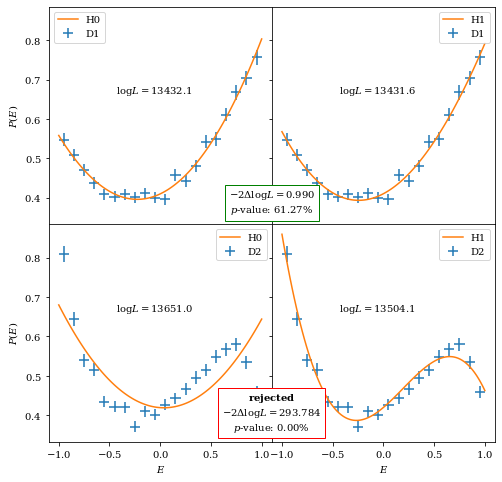

In [11]:
fig, ax = plt.subplots(ncols=2,nrows=2,
                       sharex=True,sharey=True,
                       gridspec_kw=dict(hspace=0,wspace=0),
                       figsize=(8,8))
xrng = np.linspace(-1,1,100)
for fd,ar,h in zip(comp,ax,[hist1,hist2]):
    ar[0].set_ylabel(r'$P(E)$')
    for (dn,hn,f),a in zip(fd,ar):
        # print(f'=== Data: {dn} Hypothesis: {hn} ===')
        h.plot(ax=a,label=dn,fmt='none')
        f.plot(xrng,ax=a,label=hn)
        a.text(.3,.6,fr'$\log L={-f.nllh:.1f}$',
               transform=a.transAxes)
        a.legend()
        print(f)
        
    apr = ar[1].get_position() 
    ll  = apr.bounds[0]
    bb  = apr.bounds[1] + 0.02
    
    dllh = -2*(fd[0][2].nllh - fd[1][2].nllh)
    pval = sp.stats.chi.sf(dllh,2)
    fig.text(ll,bb,
             (r'' if pval > 0.05 else r'$\mathbf{rejected}$'+'\n') +
             fr'$-2\Delta\log L={dllh:7.3f}$'+'\n'+
             fr'$p$-value: ${pval*100:.2f}\%$',
             horizontalalignment='center',
             backgroundcolor='white',
             bbox=dict(edgecolor='green' if pval > 0.05 else 'red', 
                       facecolor='white', alpha=1))
    
ax[1,0].set_xlabel(r'$E$')
ax[1,1].set_xlabel(r'$E$');

## Conclusions 

We see that 

- for the first data set we cannot reject the null-hypothesis - the alternative hypothesis does not do a better job at describing the data, while 
- for the second data set, we must reject the null-hypothesis - the alternative does a much better job, as is quite evident from the plots above, and the numbers back that intuition up. 